In [1]:
%conda install -c conda-forge matplotlib 
%conda install -c anaconda scipy
!pip install tqdm h5py zarr pillow numpy imgaug==0.4.0 mahotas #imgaug has dependency on previous packages
!pip install scikit-image
!pip install tensorboard
!pip install torchsummary

Solving environment: done

## Package Plan ##

  environment location: /home/xiaoyan/anaconda3/envs/07_instance_segmentation

  added / updated specs:
    - matplotlib


The following packages will be UPDATED:

  ca-certificates    anaconda::ca-certificates-2020.10.14-0 --> conda-forge::ca-certificates-2021.5.30-ha878542_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
Solving environment: done

## Package Plan ##

  environment location: /home/xiaoyan/anaconda3/envs/07_instance_segmentation

  added / updated specs:
    - scipy


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2021.5.3~ --> anaconda::ca-certificates-2020.10.14-0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"


import torch
from __future__ import division, print_function
from torch.utils.data import Dataset
import glob
import os
import zarr
import random
import datetime
import numpy as np

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
# import h5py
# from imgaug import augmenters as iaa
# from imgaug.augmentables.segmaps import SegmentationMapsOnImage
# from imgaug.augmentables.heatmaps import HeatmapsOnImage
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
from skimage import io
from colormap import *
from unet_fov import *

plt.rcParams['image.cmap'] = 'gist_earth'
torch.backends.cudnn.benchmark = True

In [3]:
# decompress data
from shutil import unpack_archive
unpack_archive('example_toy_data.zip', './')

In [4]:
def running_mean(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

def plot_history(history):
    # plot training and validation loss and binary accuracy
    
    loss = running_mean(history['loss'], 9)
    val_loss = running_mean(history['val_loss'], 9)
    #epochs = len(history.history['loss'])
    epochs = len(loss)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(range(0, epochs), loss , label='loss')
    ax1.plot(range(0, epochs), val_loss, label='val_loss')
    ax1.set_title('train and validation loss')
    ax1.legend(loc='upper right')
    
    acc = running_mean(history['binary_accuracy'], 9)
    val_acc = running_mean(history['val_binary_accuracy'], 9)

    ax2.plot(range(0, epochs), acc, label='binary_accuracy')
    ax2.plot(range(0, epochs), val_acc, label='val_binary_accuracy')
    ax2.set_title('train and validation binary accuracy')
    ax2.legend(loc='lower right')

    plt.show()

In [5]:
def show_predictions(raw, gt, pred):
    
    thresh = 0.9
    max_values = np.max(pred[:,0], axis=(1, 2))
    if np.any(max_values < thresh):
        print("Heads up: If prediction is below {} then the prediction map is shown.".format(thresh))
        print("Max predictions: {}".format(max_values))
    
    num_samples = pred.shape[0]
    fig, ax = plt.subplots(num_samples, 3, sharex=True, sharey=True, figsize=(12, num_samples * 4))
    for i in range(num_samples):
        ax[i, 0].imshow(raw[i,0], aspect="auto")
        ax[i, 1].imshow(gt[i,0], aspect="auto")
        # check for prediction threshold
        if np.sum(max_values[i]) < thresh:
            ax[i, 2].imshow(pred[i,0], aspect="auto")
        else:
            ax[i, 2].imshow(pred[i,0] >= thresh, aspect="auto")

    ax[0, 0].set_title("Input")
    ax[0, 1].set_title("Ground truth")
    ax[0, 2].set_title("Prediction")
    fig.tight_layout()

## (1) Load and visualize our toy data examples:


we have 12 train samples, 3 validation samples and 3 test samples.

In [6]:
# load tif images and reformat it
def load_dataset(in_folder):
    x = []
    y = []
    raw_files = glob.glob(in_folder + '/raw_*.tif')
    for raw_file in raw_files:
        x.append(io.imread(raw_file)) 
        y.append(io.imread(raw_file.replace('raw', 'gt'))) 
    x = np.array(x)[:, np.newaxis] #shape [N, 1, H, W]
    y = np.array(y)[:, np.newaxis] #shape [N, 1, H, W]
    return x, y

In [7]:
# load data into train/val/test sets
x_train, y_train = load_dataset('example_toy_data/train')
x_val, y_val = load_dataset('example_toy_data/val')
x_test, y_test = load_dataset('example_toy_data/test')

batch_size = 4
# make dataloaders
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(list(zip(x_val, y_val)), batch_size=1, pin_memory=True)
test_loader = DataLoader(list(zip(x_test, y_test)), batch_size=1)

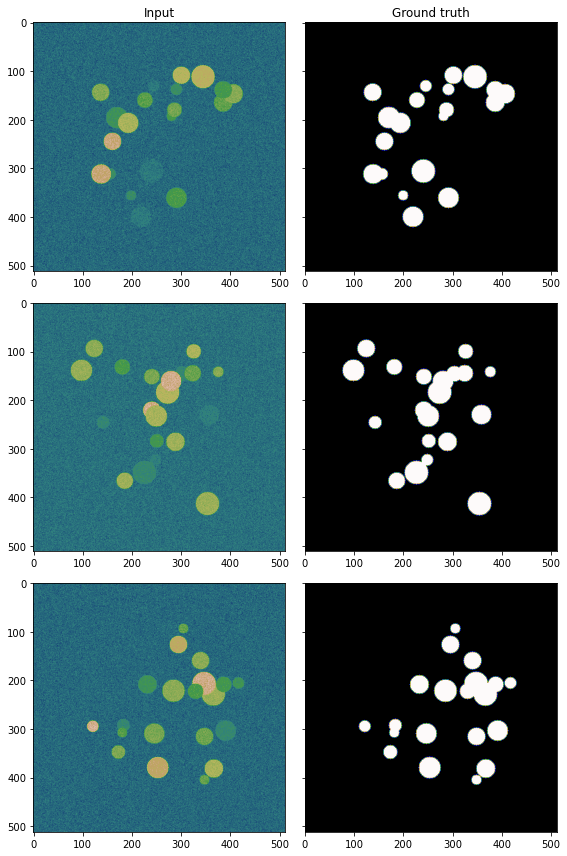

In [8]:
# show training examples
num_samples = 3
fig, ax = plt.subplots(num_samples, 2, sharey=True, figsize=(8, num_samples * 4))
for i in range(num_samples):
    ax[i, 0].imshow(x_train[i,0], aspect="auto")
    ax[i, 1].imshow(y_train[i,0], aspect="auto")
ax[0, 0].set_title("Input")
ax[0, 1].set_title("Ground truth")
fig.tight_layout()

## (2) Create and train our model

In [9]:
# set seed
torch.manual_seed(42)

# define model
out_channels = 1
d_factors = [[2,2],[2,2],[2,2],[2,2]]
activation = torch.nn.Sigmoid()

net = torch.nn.Sequential(
    UNet(in_channels=1,
    num_fmaps=6,
    fmap_inc_factors=2,
    downsample_factors=d_factors,
    activation='ReLU',
    padding='same',
    num_fmaps_out=6,
    constant_upsample=False
    ),
    torch.nn.Conv2d(in_channels=6, out_channels=out_channels, kernel_size=1, padding=0, bias=True))

receptive_field, _ = net[0].get_fov()

# print network layers
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
summary(net, (1,512,512))
print("Receptive field: ", receptive_field)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 512, 512]              60
              ReLU-2          [-1, 6, 512, 512]               0
            Conv2d-3          [-1, 6, 512, 512]             330
              ReLU-4          [-1, 6, 512, 512]               0
          ConvPass-5          [-1, 6, 512, 512]               0
         MaxPool2d-6          [-1, 6, 256, 256]               0
        Downsample-7          [-1, 6, 256, 256]               0
            Conv2d-8         [-1, 12, 256, 256]             660
              ReLU-9         [-1, 12, 256, 256]               0
           Conv2d-10         [-1, 12, 256, 256]           1,308
             ReLU-11         [-1, 12, 256, 256]               0
         ConvPass-12         [-1, 12, 256, 256]               0
        MaxPool2d-13         [-1, 12, 128, 128]               0
       Downsample-14         [-1, 12, 1

/home/xiaoyan/anaconda3/envs/07_instance_segmentation/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Receptive Field of View

The number of convolutions and the depth of the U-Net are the major factors in determining the 
receptive field of the network. The term is borrowed from biology where it describes the "portion of sensory space that can elicit neuronal responses when stimulated" (wikipedia). Each output pixel can look at/depends on an input patch with that diameter centered at its position.
Based on this patch, the network has to be able to make a decision about the prediction for the respective pixel.
Yet larger sizes increase the computation time significantly.

The following code snippet visualizes the field of view of the center pixel for networks with varying depth:

Field of view at depth 1:   5 (color: yellow)
Field of view at depth 2:  18 (color: red)
Field of view at depth 3:  44 (color: green)
Field of view at depth 4:  96 (color: blue)


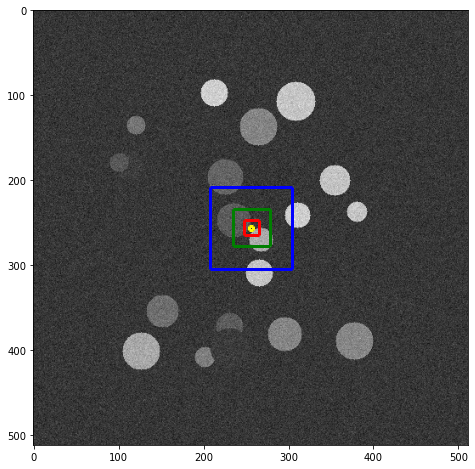

In [10]:
rnd = random.randrange(len(x_train))
image = x_train[rnd]
label = y_train[rnd]


net_t = image
fovs = []
d_factors = [[2,2],[2,2],[2,2],[2,2]]

for level in range(len(d_factors)):
    fov_tmp, _ = net[0].rec_fov(level , (1, 1), 1)
    fovs.append(fov_tmp[0])

image = np.squeeze(image)
fig=plt.figure(figsize=(8, 8))
colors = ["yellow", "red", "green", "blue", "magenta"]
plt.imshow(image, cmap='gray')
for idx, fov_t in enumerate(fovs):
    print("Field of view at depth {}: {:3d} (color: {})".format(idx+1, fov_t, colors[idx]))
    xmin = image.shape[1]/2 - fov_t/2
    xmax = image.shape[1]/2 + fov_t/2
    ymin = image.shape[1]/2 - fov_t/2
    ymax = image.shape[1]/2 + fov_t/2
    plt.hlines(ymin, xmin, xmax, color=colors[idx], lw=3)
    plt.hlines(ymax, xmin, xmax, color=colors[idx], lw=3)
    plt.vlines(xmin, ymin, ymax, color=colors[idx], lw=3)
    plt.vlines(xmax, ymin, ymax, color=colors[idx], lw=3)
plt.show()

In [11]:
dtype = torch.FloatTensor
def training_step(model, loss_fn, optimizer, feature, label):
    # speedup version of setting gradients to zero
    for param in model.parameters():
        param.grad = None
    # forward
    logits = model(feature) # B x C x H x W
    loss_value = loss_fn(input=logits, target=label) # label.squeeze(0) for three_class
    # backward if training mode
    if net.training:
        loss_value.backward()
        optimizer.step()
    if activation is not None:
        output = activation(logits)
    else:
        output = logits
    outputs = {
        'pred': output,
        'logits': logits,
    }
    return loss_value, outputs

def calc_accuracy(y_pred, y_true):
    y_pred=torch.ge(y_pred, 0.5)
   # y_pred = torch.round(y_pred)
    return y_pred.eq(y_true).float().mean()
                
def train(net, epochs, learning_rate,start_epoch=0, optimizer=None, history=None, early_stopping=None,img_gen=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    loss_fn = loss_fn.to(device)
    # set optimizer
    if optimizer is None:
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 
    if history is None:
        history = {'loss':[],
                  'val_loss':[],
                  'binary_accuracy':[],
                  'val_binary_accuracy':[]}
    if img_gen:
        pbar = tqdm(total=epochs)
    else:
        pbar = tqdm(total=epochs*len(train_loader))
    for epoch in range(0, epochs):
    #for epoch in tqdm(range(0, epochs)):
        
        if img_gen:
            net.train()
            train_acc_loss = []
            train_acc_accuracy = []
            feature,label=next(img_gen)
            label = label.type(dtype)
            label = label.to(device)
            feature = feature.to(device)
            loss_value, outputs = training_step(net, loss_fn, optimizer, feature, label)
            pbar.update(1)
            train_acc_loss.append(loss_value.cpu().detach().numpy())
            accuracy = calc_accuracy(outputs['pred'], label)
            train_acc_accuracy.append(float(accuracy.cpu().detach().numpy()))
        else:
            # reset data loader to get random augmentations
            np.random.seed()
            tmp_loader = iter(train_loader)
            train_acc_loss = []
            train_acc_accuracy = []
            net.train()
            for feature, label in tmp_loader:
                label = label.type(dtype)
                label = label.to(device)
                feature = feature.to(device)
                loss_value, outputs = training_step(net, loss_fn, optimizer, feature, label)
                pbar.update(1)
                train_acc_loss.append(loss_value.cpu().detach().numpy())
                accuracy = calc_accuracy(outputs['pred'], label)
                train_acc_accuracy.append(float(accuracy.cpu().detach().numpy()))
        history['loss'].append(np.mean(train_acc_loss))
        history['binary_accuracy'].append(np.mean(train_acc_accuracy))
        # validation
        net.eval()
        tmp_val_loader = iter(val_loader)
        val_acc_loss = []
        val_acc_accuracy = []
        for feature, label in tmp_val_loader:                    
            label = label.type(dtype)
            label = label.to(device)
            feature = feature.to(device)
            loss_value, outputs = training_step(net, loss_fn, optimizer, feature, label)
            val_acc_loss.append(loss_value.cpu().detach().numpy())
            accuracy = calc_accuracy(outputs['pred'], label)
            val_acc_accuracy.append(float(accuracy.cpu().detach().numpy()))
        history['val_loss'].append(np.mean(val_acc_loss))
        history['val_binary_accuracy'].append(np.mean(val_acc_accuracy))
        if early_stopping:
            #early_stopping(np.mean(acc_loss))
            early_stopping(np.mean(val_acc_loss))
            if early_stopping.early_stop:
                print('Early stopping after epoch', epoch)
                break
        print(f'Epoch {epoch+start_epoch+1}, train-loss: {np.mean(train_acc_loss):.4f} - train_accuracy:{np.mean(train_acc_accuracy):.4f}'+
      f' - val_loss:{np.mean(val_acc_loss):.4f} -val_accuracy:{np.mean(val_acc_accuracy):.4f}')
    return net, history, optimizer

In [12]:
num_epochs1 = 250
net, history, optimizer = train(net, num_epochs1, learning_rate=5e-4,start_epoch=0)

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1, train-loss: 0.6425 - train_accuracy:0.9295 - val_loss:0.6399 -val_accuracy:0.9294
Epoch 2, train-loss: 0.6386 - train_accuracy:0.9295 - val_loss:0.6360 -val_accuracy:0.9294
Epoch 3, train-loss: 0.6345 - train_accuracy:0.9295 - val_loss:0.6321 -val_accuracy:0.9294
Epoch 4, train-loss: 0.6309 - train_accuracy:0.9295 - val_loss:0.6291 -val_accuracy:0.9294
Epoch 5, train-loss: 0.6285 - train_accuracy:0.9295 - val_loss:0.6271 -val_accuracy:0.9294
Epoch 6, train-loss: 0.6264 - train_accuracy:0.9295 - val_loss:0.6251 -val_accuracy:0.9294
Epoch 7, train-loss: 0.6243 - train_accuracy:0.9295 - val_loss:0.6230 -val_accuracy:0.9294
Epoch 8, train-loss: 0.6222 - train_accuracy:0.9295 - val_loss:0.6207 -val_accuracy:0.9294
Epoch 9, train-loss: 0.6198 - train_accuracy:0.9295 - val_loss:0.6182 -val_accuracy:0.9294
Epoch 10, train-loss: 0.6172 - train_accuracy:0.9295 - val_loss:0.6152 -val_accuracy:0.9294
Epoch 11, train-loss: 0.6140 - train_accuracy:0.9295 - val_loss:0.6116 -val_accuracy:0.92

Epoch 93, train-loss: 0.0763 - train_accuracy:0.9758 - val_loss:0.0782 -val_accuracy:0.9739
Epoch 94, train-loss: 0.0790 - train_accuracy:0.9727 - val_loss:0.1569 -val_accuracy:0.9593
Epoch 95, train-loss: 0.0801 - train_accuracy:0.9721 - val_loss:0.0753 -val_accuracy:0.9752
Epoch 96, train-loss: 0.0776 - train_accuracy:0.9750 - val_loss:0.0764 -val_accuracy:0.9748
Epoch 97, train-loss: 0.0741 - train_accuracy:0.9747 - val_loss:0.0910 -val_accuracy:0.9731
Epoch 98, train-loss: 0.0742 - train_accuracy:0.9766 - val_loss:0.0728 -val_accuracy:0.9759
Epoch 99, train-loss: 0.0731 - train_accuracy:0.9756 - val_loss:0.1110 -val_accuracy:0.9641
Epoch 100, train-loss: 0.0753 - train_accuracy:0.9743 - val_loss:0.0712 -val_accuracy:0.9770
Epoch 101, train-loss: 0.0694 - train_accuracy:0.9771 - val_loss:0.1276 -val_accuracy:0.9639
Epoch 102, train-loss: 0.0757 - train_accuracy:0.9766 - val_loss:0.0683 -val_accuracy:0.9770
Epoch 103, train-loss: 0.0711 - train_accuracy:0.9761 - val_loss:0.0752 -val_

Epoch 184, train-loss: 0.0382 - train_accuracy:0.9879 - val_loss:0.0464 -val_accuracy:0.9827
Epoch 185, train-loss: 0.0387 - train_accuracy:0.9863 - val_loss:0.0463 -val_accuracy:0.9851
Epoch 186, train-loss: 0.0388 - train_accuracy:0.9866 - val_loss:0.0361 -val_accuracy:0.9885
Epoch 187, train-loss: 0.0351 - train_accuracy:0.9878 - val_loss:0.3401 -val_accuracy:0.8532
Epoch 188, train-loss: 0.0715 - train_accuracy:0.9809 - val_loss:0.0584 -val_accuracy:0.9823
Epoch 189, train-loss: 0.0870 - train_accuracy:0.9766 - val_loss:0.0685 -val_accuracy:0.9795
Epoch 190, train-loss: 0.0710 - train_accuracy:0.9799 - val_loss:0.0627 -val_accuracy:0.9795
Epoch 191, train-loss: 0.0646 - train_accuracy:0.9798 - val_loss:0.0620 -val_accuracy:0.9803
Epoch 192, train-loss: 0.0670 - train_accuracy:0.9774 - val_loss:0.0639 -val_accuracy:0.9786
Epoch 193, train-loss: 0.0597 - train_accuracy:0.9813 - val_loss:0.0675 -val_accuracy:0.9826
Epoch 194, train-loss: 0.0563 - train_accuracy:0.9822 - val_loss:0.052

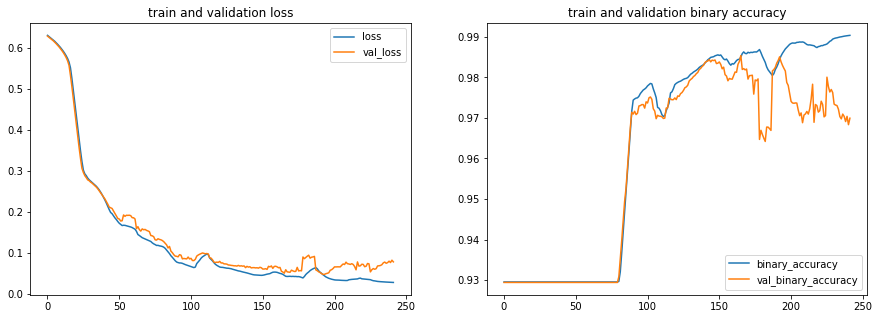

In [13]:
# plot loss and accuracy
plot_history(history)

## (3) Test and evaluate our model

Accuracy: 0.990


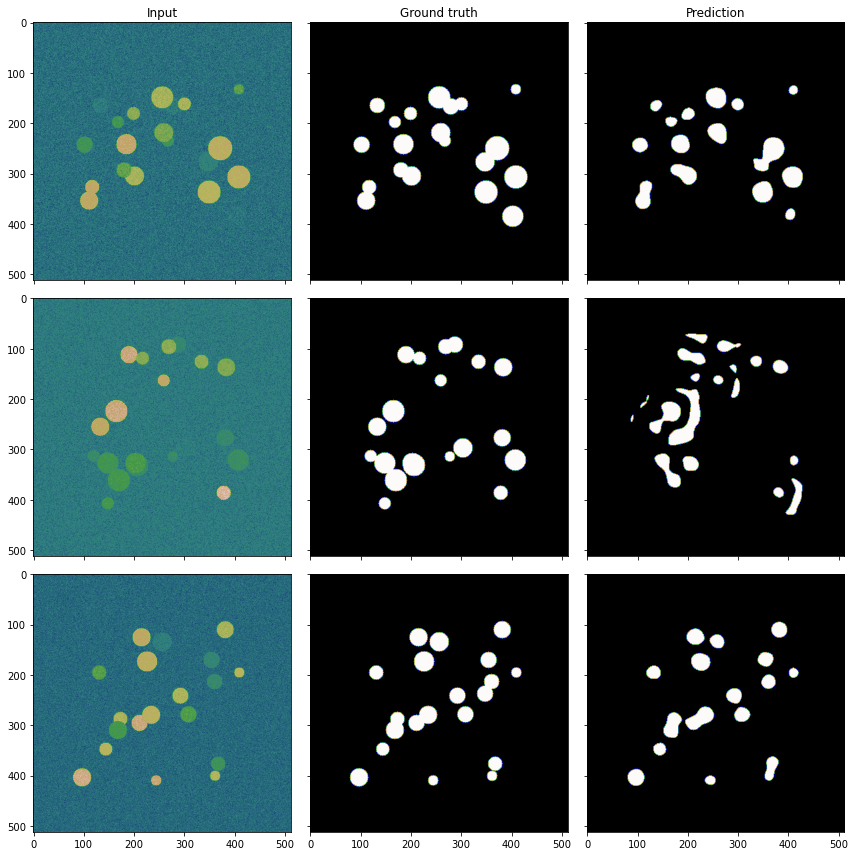

In [14]:
# predict the test set
def predict(net, test_loader):
    net.eval()
    predictions = []
    acc_accuracy = []
    for image, label in test_loader:
        image = image.to(device)
        label = label.to(device)
        pred = net(image)
        pred = activation(pred)
        accuracy = calc_accuracy(pred, label)
        acc_accuracy.append(float(accuracy.cpu().detach().numpy()))
        image = np.squeeze(image.cpu())
        pred = np.squeeze(pred.cpu().detach().numpy(),0)
        predictions.append(pred)
    acc_accuracy = []
    return predictions, float(accuracy.cpu().numpy())
    
# plot predicted results
predictions, accuracy = predict(net, test_loader)
predictions = np.stack(predictions, axis=0)
print('Accuracy: {:.3f}'.format(accuracy))
show_predictions(x_test, y_test, predictions)

### A1: Continue training for more epochs

In [15]:
# continue training, takes ~3min
# heads up: the "net" variable still carries all the information from the previous training
num_epochs2=160
net, continued_history, optimizer = train(net, epochs=num_epochs2, learning_rate=1e-4, start_epoch=num_epochs1,history=history, optimizer=optimizer)

print('Finished Training')

  0%|          | 0/480 [00:00<?, ?it/s]

Epoch 251, train-loss: 0.0289 - train_accuracy:0.9904 - val_loss:0.0484 -val_accuracy:0.9817
Epoch 252, train-loss: 0.0272 - train_accuracy:0.9907 - val_loss:0.1297 -val_accuracy:0.9518
Epoch 253, train-loss: 0.0317 - train_accuracy:0.9894 - val_loss:0.0292 -val_accuracy:0.9899
Epoch 254, train-loss: 0.0333 - train_accuracy:0.9882 - val_loss:0.0325 -val_accuracy:0.9890
Epoch 255, train-loss: 0.0299 - train_accuracy:0.9890 - val_loss:0.1126 -val_accuracy:0.9562
Epoch 256, train-loss: 0.0304 - train_accuracy:0.9898 - val_loss:0.0353 -val_accuracy:0.9883
Epoch 257, train-loss: 0.0346 - train_accuracy:0.9891 - val_loss:0.0317 -val_accuracy:0.9893
Epoch 258, train-loss: 0.0313 - train_accuracy:0.9889 - val_loss:0.0387 -val_accuracy:0.9858
Epoch 259, train-loss: 0.0308 - train_accuracy:0.9893 - val_loss:0.0568 -val_accuracy:0.9772
Epoch 260, train-loss: 0.0305 - train_accuracy:0.9897 - val_loss:0.0337 -val_accuracy:0.9883
Epoch 261, train-loss: 0.0291 - train_accuracy:0.9900 - val_loss:0.031

Epoch 342, train-loss: 0.0198 - train_accuracy:0.9927 - val_loss:0.0434 -val_accuracy:0.9843
Epoch 343, train-loss: 0.0195 - train_accuracy:0.9928 - val_loss:0.0489 -val_accuracy:0.9816
Epoch 344, train-loss: 0.0194 - train_accuracy:0.9927 - val_loss:0.0595 -val_accuracy:0.9776
Epoch 345, train-loss: 0.0194 - train_accuracy:0.9929 - val_loss:0.0386 -val_accuracy:0.9859
Epoch 346, train-loss: 0.0192 - train_accuracy:0.9928 - val_loss:0.0543 -val_accuracy:0.9797
Epoch 347, train-loss: 0.0192 - train_accuracy:0.9928 - val_loss:0.0396 -val_accuracy:0.9854
Epoch 348, train-loss: 0.0191 - train_accuracy:0.9928 - val_loss:0.0489 -val_accuracy:0.9818
Epoch 349, train-loss: 0.0192 - train_accuracy:0.9928 - val_loss:0.0351 -val_accuracy:0.9874
Epoch 350, train-loss: 0.0187 - train_accuracy:0.9931 - val_loss:0.0537 -val_accuracy:0.9800
Epoch 351, train-loss: 0.0190 - train_accuracy:0.9928 - val_loss:0.0487 -val_accuracy:0.9817
Epoch 352, train-loss: 0.0186 - train_accuracy:0.9929 - val_loss:0.035

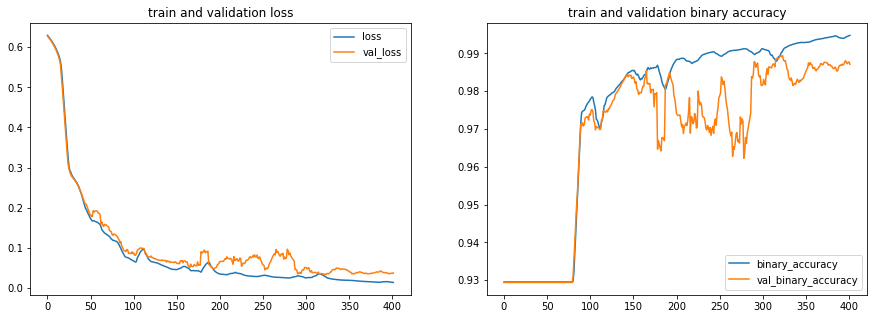

In [16]:
# plot loss and accuracy
plot_history(history)

In [17]:
test = predictions[0][0]

Accuracy: 0.993


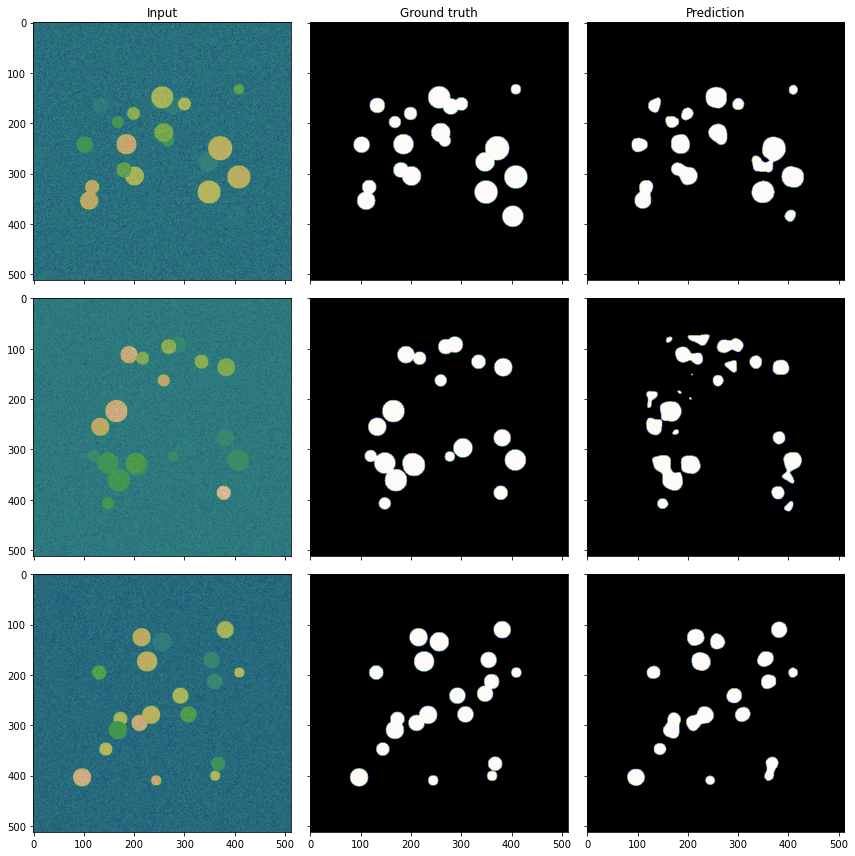

In [18]:
# evaluate and plot predicted results
predictions, accuracy = predict(net, test_loader)
predictions = np.stack(predictions, axis=0)
print('Accuracy: {:.3f}'.format(accuracy))
show_predictions(x_test, y_test, predictions)

#### The training of the networks depend on many hyperparameters such as
- network architecture: #layers, #fmaps
- batch size, learning rate
- number and distribution of the training samples

#### You can play and see how these settings influence the learning curve.

![](example_learning_curves/lc_all.png)

### A2: Use early stopping to avoid overfitting

In [19]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    Code from https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
    """
    def __init__(self, patience=20, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [20]:
# define model
out_channels = 1
d_factors = [[2,2],[2,2],[2,2],[2,2]]
activation = torch.nn.Sigmoid()
early_stopping = EarlyStopping(patience=60)

net = torch.nn.Sequential(
    UNet(in_channels=1,
    num_fmaps=6,
    fmap_inc_factors=2,
    downsample_factors=d_factors,
    activation='ReLU',
    padding='same',
    num_fmaps_out=6,
    constant_upsample=False
    ),
    torch.nn.Conv2d(in_channels=6, out_channels=out_channels, kernel_size=1, padding=0, bias=True))

In [21]:
# train model
epochs = 500
net, history_w_ea,_ = train(net, epochs, learning_rate=5e-4, early_stopping=early_stopping)
print('Finished Training')

  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 1, train-loss: 0.5456 - train_accuracy:0.9295 - val_loss:0.5452 -val_accuracy:0.9294
Epoch 2, train-loss: 0.5448 - train_accuracy:0.9295 - val_loss:0.5441 -val_accuracy:0.9294
Epoch 3, train-loss: 0.5436 - train_accuracy:0.9295 - val_loss:0.5428 -val_accuracy:0.9294
Epoch 4, train-loss: 0.5423 - train_accuracy:0.9295 - val_loss:0.5413 -val_accuracy:0.9294
Epoch 5, train-loss: 0.5408 - train_accuracy:0.9295 - val_loss:0.5397 -val_accuracy:0.9294
Epoch 6, train-loss: 0.5390 - train_accuracy:0.9295 - val_loss:0.5376 -val_accuracy:0.9294
Epoch 7, train-loss: 0.5367 - train_accuracy:0.9295 - val_loss:0.5348 -val_accuracy:0.9294
Epoch 8, train-loss: 0.5338 - train_accuracy:0.9295 - val_loss:0.5318 -val_accuracy:0.9294
Epoch 9, train-loss: 0.5308 - train_accuracy:0.9295 - val_loss:0.5286 -val_accuracy:0.9294
Epoch 10, train-loss: 0.5275 - train_accuracy:0.9295 - val_loss:0.5250 -val_accuracy:0.9294
Epoch 11, train-loss: 0.5238 - train_accuracy:0.9295 - val_loss:0.5210 -val_accuracy:0.92

Epoch 93, train-loss: 0.0493 - train_accuracy:0.9845 - val_loss:0.0514 -val_accuracy:0.9828
Epoch 94, train-loss: 0.0608 - train_accuracy:0.9841 - val_loss:0.0580 -val_accuracy:0.9850
Epoch 95, train-loss: 0.0790 - train_accuracy:0.9811 - val_loss:0.0452 -val_accuracy:0.9883
Epoch 96, train-loss: 0.0679 - train_accuracy:0.9853 - val_loss:0.0497 -val_accuracy:0.9880
Epoch 97, train-loss: 0.0500 - train_accuracy:0.9880 - val_loss:0.4454 -val_accuracy:0.7230
Epoch 98, train-loss: 0.0740 - train_accuracy:0.9758 - val_loss:0.0554 -val_accuracy:0.9866
Epoch 99, train-loss: 0.1036 - train_accuracy:0.9827 - val_loss:0.0938 -val_accuracy:0.9819
Epoch 100, train-loss: 0.0951 - train_accuracy:0.9813 - val_loss:0.0546 -val_accuracy:0.9820
Epoch 101, train-loss: 0.0641 - train_accuracy:0.9802 - val_loss:0.1595 -val_accuracy:0.9701
Epoch 102, train-loss: 0.0725 - train_accuracy:0.9791 - val_loss:0.0624 -val_accuracy:0.9807
Epoch 103, train-loss: 0.0686 - train_accuracy:0.9791 - val_loss:0.0607 -val_

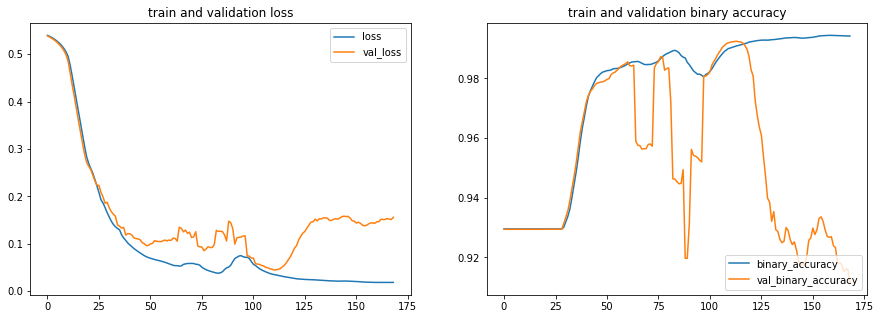

In [22]:
# plot loss and accuracy
plot_history(history_w_ea)

Accuracy: 0.994


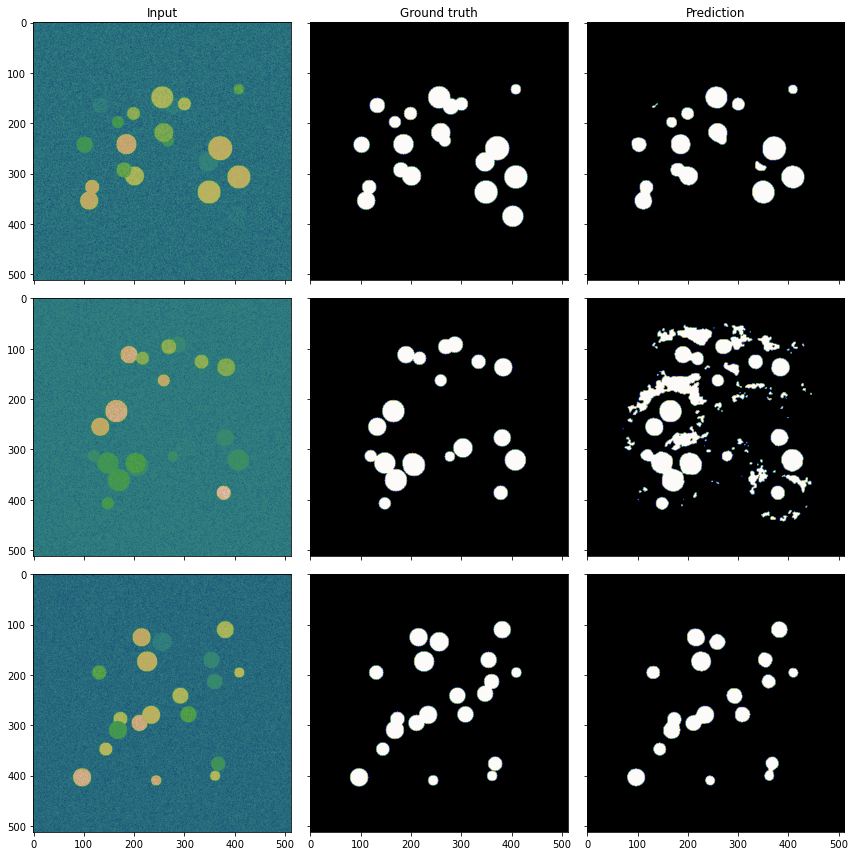

In [23]:
# evaluate and plot predicted results
predictions, accuracy = predict(net, test_loader)
predictions = np.stack(predictions, axis=0)
print('Accuracy: {:.3f}'.format(accuracy))
show_predictions(x_test, y_test, predictions)

### A3: Use a data generator to avoid overfitting

In [24]:
# As we have simulated data, we can use unlimited number of training examples
# image generator copied from https://github.com/jakeret/tf_unet
import image_gen

In [25]:
# define image shape
nx = 512
ny = 512

# create a wrapper generator 
def train_generator(batch_size):
    
    # init image generator with the following parameters:
    # nx, ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, limit_num_samples = -1, binary = True
    #generator = image_gen.GrayScaleDataProvider(nx, ny, cnt=20, r_min=10, r_max=25, binary=True)
    data_generator = image_gen.GrayScaleDataProvider(nx, ny, cnt=20, r_min=10, r_max=25, binary=True)
   # batch_labels = np.zeros((batch_size, 1)) 
    while True:
        data, labels = data_generator(batch_size)
        data=torch.tensor(data).type(torch.FloatTensor)
        labels=torch.tensor(labels)
        yield data, labels

In [42]:
# define model
out_channels = 1
d_factors = [[2,2],[2,2],[2,2],[2,2]]
activation = torch.nn.Sigmoid()
early_stopping = EarlyStopping(patience=60)

net = torch.nn.Sequential(
    UNet(in_channels=1,
    num_fmaps=6,
    fmap_inc_factors=2,
    downsample_factors=d_factors,
    activation='ReLU',
    padding='same',
    num_fmaps_out=6,
    constant_upsample=False
    ),
    torch.nn.Conv2d(in_channels=6, out_channels=out_channels, kernel_size=1, padding=0, bias=True))

In [43]:
# train model
epochs = 200
net, history_w_gen,_ = train(net, epochs, learning_rate=8e-3, early_stopping=early_stopping,img_gen=iter(train_generator(4)))
print('Finished Training')

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, train-loss: 0.7523 - train_accuracy:0.0670 - val_loss:0.7313 -val_accuracy:0.0706
Epoch 2, train-loss: 0.7315 - train_accuracy:0.0689 - val_loss:0.7046 -val_accuracy:0.0706
Epoch 3, train-loss: 0.7048 - train_accuracy:0.0661 - val_loss:0.6214 -val_accuracy:0.9293
Epoch 4, train-loss: 0.6214 - train_accuracy:0.9299 - val_loss:1.7436 -val_accuracy:0.9294
Epoch 5, train-loss: 1.7861 - train_accuracy:0.9277 - val_loss:0.5451 -val_accuracy:0.9294
Epoch 6, train-loss: 0.5441 - train_accuracy:0.9323 - val_loss:0.6256 -val_accuracy:0.9294
Epoch 7, train-loss: 0.6249 - train_accuracy:0.9344 - val_loss:0.6340 -val_accuracy:0.9294
Epoch 8, train-loss: 0.6343 - train_accuracy:0.9279 - val_loss:0.6317 -val_accuracy:0.9294
Epoch 9, train-loss: 0.6313 - train_accuracy:0.9328 - val_loss:0.6242 -val_accuracy:0.9294
Epoch 10, train-loss: 0.6235 - train_accuracy:0.9345 - val_loss:0.6089 -val_accuracy:0.9294
Epoch 11, train-loss: 0.6087 - train_accuracy:0.9304 - val_loss:0.5688 -val_accuracy:0.92

Epoch 91, train-loss: 0.0543 - train_accuracy:0.9846 - val_loss:0.0555 -val_accuracy:0.9887
Epoch 92, train-loss: 0.0370 - train_accuracy:0.9896 - val_loss:0.0449 -val_accuracy:0.9892
Epoch 93, train-loss: 0.0478 - train_accuracy:0.9870 - val_loss:0.0411 -val_accuracy:0.9895
Epoch 94, train-loss: 0.0420 - train_accuracy:0.9880 - val_loss:0.0402 -val_accuracy:0.9896
Epoch 95, train-loss: 0.0716 - train_accuracy:0.9865 - val_loss:0.0429 -val_accuracy:0.9896
Epoch 96, train-loss: 0.1065 - train_accuracy:0.9824 - val_loss:0.0803 -val_accuracy:0.9879
Epoch 97, train-loss: 0.0841 - train_accuracy:0.9855 - val_loss:0.0444 -val_accuracy:0.9898
Epoch 98, train-loss: 0.0475 - train_accuracy:0.9896 - val_loss:0.0432 -val_accuracy:0.9900
Epoch 99, train-loss: 0.0323 - train_accuracy:0.9881 - val_loss:0.0443 -val_accuracy:0.9901
Epoch 100, train-loss: 0.0241 - train_accuracy:0.9928 - val_loss:0.0455 -val_accuracy:0.9902
Epoch 101, train-loss: 0.0411 - train_accuracy:0.9887 - val_loss:0.0488 -val_ac

Epoch 181, train-loss: 0.0331 - train_accuracy:0.9893 - val_loss:0.0365 -val_accuracy:0.9904
Epoch 182, train-loss: 0.0432 - train_accuracy:0.9869 - val_loss:0.0377 -val_accuracy:0.9906
Epoch 183, train-loss: 0.0299 - train_accuracy:0.9924 - val_loss:0.0397 -val_accuracy:0.9907
Epoch 184, train-loss: 0.0316 - train_accuracy:0.9913 - val_loss:0.0421 -val_accuracy:0.9907
Epoch 185, train-loss: 0.0552 - train_accuracy:0.9841 - val_loss:0.0463 -val_accuracy:0.9908
Epoch 186, train-loss: 0.0325 - train_accuracy:0.9910 - val_loss:0.0504 -val_accuracy:0.9908
Epoch 187, train-loss: 0.0672 - train_accuracy:0.9836 - val_loss:0.0586 -val_accuracy:0.9907
Early stopping after epoch 187
Finished Training


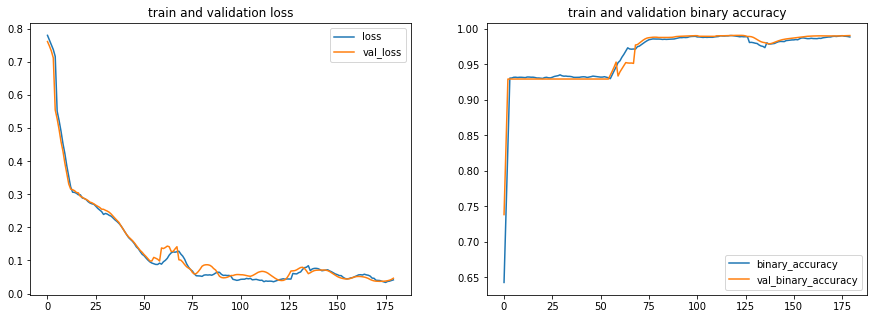

In [44]:
# plot loss and accuracy
plot_history(history_w_gen)

Accuracy: 0.990


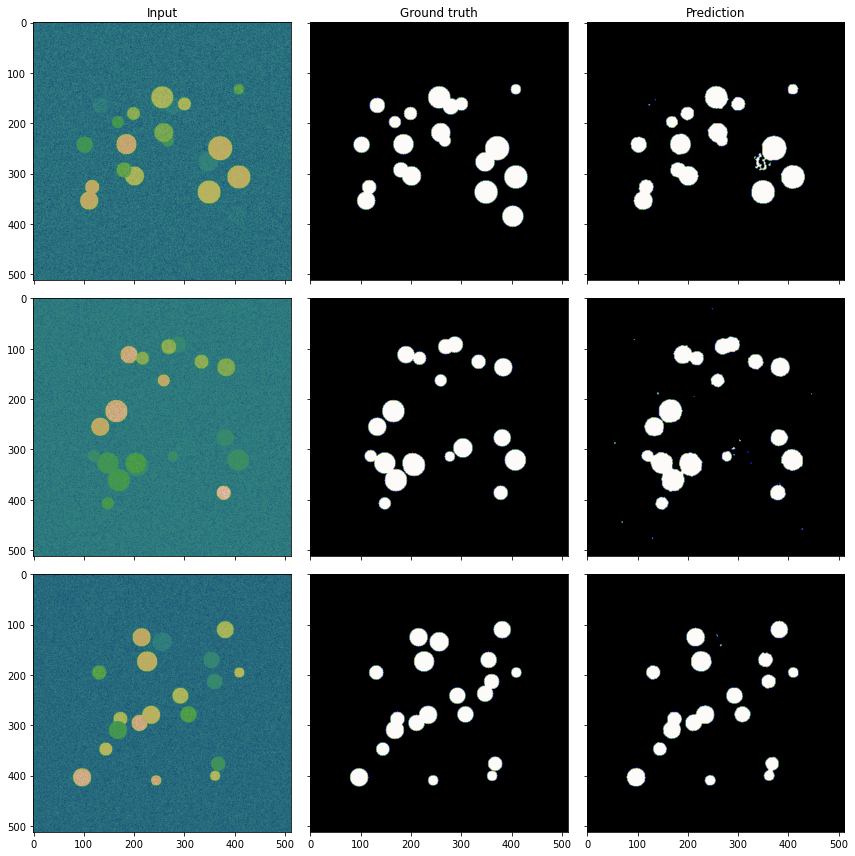

In [45]:
# evaluate and plot predicted results
predictions, accuracy = predict(net, test_loader)
predictions = np.stack(predictions, axis=0)
print('Accuracy: {:.3f}'.format(accuracy))
show_predictions(x_test, y_test, predictions)